<a href="https://colab.research.google.com/github/alibekk93/soccer_fun_stuff/blob/main/TM_player_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Simple evaluation of players' seasons using TransferMarkt statistics. Looking at:
1.   player in team - minutes per season
2.   team in league - points per game
3.   league in world - mean player value in league (inflation adjusted)

# Setup

## Libraries

In [1]:
# essential ones
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [2]:
!pip install requests_html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.4/83.4 KB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 KB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.0/107.0 KB 1.0 MB/s eta 0:00:00
  Created wheel for parse: filename=parse-1.19.0-py3-none-any.whl size=24591 sha256=270d938ddc4f09165f9ddb96711ddab61433a07f71bdf7437ce28254ac166847
  Stored in directory: /root/.cache/pip/wheels/e5/33/1f/68392720485b3ecf125a69e700baaab7624616deedea2fa6e2
Successfully built parse
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [3]:
import requests
from requests_html import HTMLSession
from bs4 import BeautifulSoup

In [4]:
session = HTMLSession()

## Functions

In [5]:
#@title ### simple get table function

def get_TM_table(url:str, table_idx:int=0, get_links:bool=False) -> pd.DataFrame:
  """A simple function to get data from a table and return in a DataFrame
  -----------
  Parameters:
  url (str): url of the page where the table is located
  table_idx (int): index of the table on the page, starting from 0. Default value is 0 (first table on the page)
  get_links (bool): whether links from table should be returned (as a list). False by default
  
  Returns:
  pd.DataFrame

  """

  # get html
  r = session.get(url)
  soup = BeautifulSoup(r.html.raw_html)
  # find table and process data into dataframe
  table = soup.findAll('table')[table_idx]
  headers = [a.text for a in table.find('thead').findAll('a')]
  data = [d.text for d in table.find('tbody').findAll('td')]
  df = pd.DataFrame(np.array(data).reshape(-1, len(headers)), columns=headers)
  # get links if needed
  if get_links == True:
    links = [a['href'] for a in table.find('tbody').findAll('a')]
    return df, links
  else:
    return df

In [75]:
#@title ### make a float from a string for a value

def value_str_to_float(value_str:str) -> float:
  """Get float value from a string

  -----------
  Parameters:
  value_str (str): player value as a string

  Returns:
  float

  """

  # find if value is thousands or millions
  if value_str[-1] == 'k':
    # value is in thousands, e.g. €212k
    return float(value_str[1:-1]) * 1000
  else:
    # 3 value is in millions, e.g. €9.81m
    return float(value_str[1:-1]) * 1000000

In [121]:
#@title ### obtain mean player value for a specific season and league

def league_mean_value(league_url:str, season:int) -> float:
  """Get mean player value from top 5 leagues for a season

  -----------
  Parameters:
  league_url (str): league url in TransferMarkt
  season (int): season for which to get the mean value

  Returns:
  float

  """

  # make url
  url = '{}/plus/?saison_id={}'.format(league_url, season)
  print(url)
  # get html
  r = session.get(url)
  soup = BeautifulSoup(r.html.raw_html)
  # find mean value for the league
  infoblock = soup.find('div', attrs={'class':'data-header__details'})
  mean_value = [span.text.replace('\n', '').replace(' ', '') for span in infoblock.findAll('span')][4]
  return value_str_to_float(mean_value)

In [117]:
#@title ### obtain top5 mean player value for a specific season

def top5_mean_value(season:int) -> float:
  """Get mean player value from top 5 leagues for a season

  -----------
  Parameters:
  season (int): season for which to get the mean value

  Returns:
  float

  """

  top_leagues_urls = ['https://www.transfermarkt.com/premier-league/startseite/wettbewerb/GB1',
                      'https://www.transfermarkt.com/primera-division/startseite/wettbewerb/ES1',
                      'https://www.transfermarkt.com/bundesliga/startseite/wettbewerb/L1',
                      'https://www.transfermarkt.com/serie-a/startseite/wettbewerb/IT1',
                      'https://www.transfermarkt.com/ligue-1/startseite/wettbewerb/FR1']
  # set mean value to 0
  mean_value = 0
  # loop with getting mean values for each league
  for url in top_leagues_urls:
    mean_value += league_mean_value(url, season)
    print(mean_value)
  return mean_value / 5

In [118]:
top5_mean_value(1990)

19400000.0
29210000.0
37480000.0
45530000.0
51870000.0


10374000.0

In [115]:
top5_mean_value(2000)

10374000.0

In [123]:
league_mean_value('https://www.transfermarkt.com/premier-league/startseite/wettbewerb/GB1', 2020)

### need to fix this function - the place when the value is taken from is static...

https://www.transfermarkt.com/premier-league/startseite/wettbewerb/GB1/plus/?saison_id=2020


19400000.0

In [109]:
top5_values_history = {}
for season in tqdm(range(1990, 2023)):
  top5_values_history[season] = top5_mean_value(season)

100%|██████████| 33/33 [16:30<00:00, 30.02s/it]


In [113]:
pd.Series(top5_values_history)

1990    10374000.0
1991    10374000.0
1992    10374000.0
1993    10374000.0
1994    10374000.0
1995    10374000.0
1996    10374000.0
1997    10374000.0
1998    10374000.0
1999    10374000.0
2000    10374000.0
2001    10374000.0
2002    10374000.0
2003    10374000.0
2004    10374000.0
2005    10374000.0
2006    10374000.0
2007    10374000.0
2008    10374000.0
2009    10374000.0
2010    10374000.0
2011    10374000.0
2012    10374000.0
2013    10374000.0
2014    10374000.0
2015    10374000.0
2016    10374000.0
2017    10374000.0
2018    10374000.0
2019    10374000.0
2020    10374000.0
2021    10374000.0
2022    10374000.0
dtype: float64

In [ ]:
url = 'https://www.transfermarkt.com/thiago/leistungsdatendetails/spieler/60444/saison//verein/0/liga/1/wettbewerb//pos/0/trainer_id/0/plus/1'

test, test1 = get_TM_table(url, table_idx=1, get_links=True)

In [ ]:
test1

['/premier-league/startseite/wettbewerb/GB1/saison_id/2022',
 '/fc-liverpool/startseite/verein/31/saison_id/2022',
 '/thiago/leistungsdatendetails/spieler/60444/plus/1/verein/31',
 '/premier-league/startseite/wettbewerb/GB1/saison_id/2021',
 '/fc-liverpool/startseite/verein/31/saison_id/2021',
 '/thiago/leistungsdatendetails/spieler/60444/plus/1/verein/31',
 '/premier-league/startseite/wettbewerb/GB1/saison_id/2020',
 '/fc-liverpool/startseite/verein/31/saison_id/2020',
 '/thiago/leistungsdatendetails/spieler/60444/plus/1/verein/31',
 '/bundesliga/startseite/wettbewerb/L1/saison_id/2019',
 '/fc-bayern-munchen/startseite/verein/27/saison_id/2019',
 '/thiago/leistungsdatendetails/spieler/60444/plus/1/verein/27',
 '/bundesliga/startseite/wettbewerb/L1/saison_id/2018',
 '/fc-bayern-munchen/startseite/verein/27/saison_id/2018',
 '/thiago/leistungsdatendetails/spieler/60444/plus/1/verein/27',
 '/bundesliga/startseite/wettbewerb/L1/saison_id/2017',
 '/fc-bayern-munchen/startseite/verein/27/sa

## Inflation calculation

# Getting data



We will need to calculate inflation

In [ ]:
def convert_age(str_age:str) -> float:
  """Converts age of FBRef format into float, e.g. '12-345' to 12.945
  """

  years, days = (float(s) for s in str_age.split('-'))
  days /= 365
  return years + days

In [ ]:
# get html
r = session.get('https://fbref.com/en/comps/Big5/keepersadv/players/Big-5-European-Leagues-Stats')
soup = BeautifulSoup(r.html.raw_html)
# find table and process data into dataframe
table = soup.findAll('table')[0]
headers = table.find('thead').findAll('tr')[1].text.split('\n')[2:-1]
rows = table.find('tbody').findAll('tr')
data = [r.findAll('td') for r in rows]
data = pd.DataFrame(np.array([row[col].text for row in data for col in range(len(row))]).reshape(-1, 34), columns=headers)
# renaming some columns for better aestetics
data.columns = ['Player', 'Nation', 'Pos', 'Squad', 'Comp', 'Age', 'Born', 'Played90s', 'GA',
                'PKA', 'FK', 'CK', 'OG', 'PSxG', 'PSxG_perSoT', 'PSxG_diff', 'PSxG_diff_per90', 'Cmp',
                'Att', 'Cmp_p', 'PassAtt', 'PassThr', 'PassLaunch_p', 'PassAvgLen', 'GKAtt', 'GKLaunch_p',
                'GKAvgLen', 'CrossAtt', 'CrossStp', 'CrossStp%', 'nOPA', 'nOPA_per90', 'AvgDistOPA', 'Matches']
# convert data
data.Age = data.Age.apply(convert_age)
NUMERIC = ['Age', 'Born', 'Played90s', 'GA', 'PKA', 'FK', 'CK', 'OG', 'PSxG', 'PSxG_perSoT', 'PSxG_diff',
           'PSxG_diff_per90', 'Cmp', 'Att', 'Cmp_p', 'PassAtt', 'PassThr', 'PassLaunch_p', 'PassAvgLen',
           'GKAtt', 'GKLaunch_p', 'GKAvgLen', 'CrossAtt', 'CrossStp', 'CrossStp%', 'nOPA', 'nOPA_per90', 'AvgDistOPA']
for col in NUMERIC:
  data[col] = pd.to_numeric(data[col], errors='coerce')

DIVISIBLES = ['Cmp', 'Att', 'PassAtt', 'PassThr', 'GKAtt', 'CrossAtt', 'CrossStp']
for col in DIVISIBLES:
  colName = col + '_per90'
  data[colName] = data[col] / data.Played90s

NUMERIC += [colName + '_per90' for colName in DIVISIBLES]

In [ ]:
data_filtered = data[data.Played90s >= 10]
data_filtered = data_filtered.dropna()

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

PCA_COLUMNS_PASSING = ['PassAtt_per90', 'PassThr_per90', 'PassLaunch_p', 'PassAvgLen']

PCA_COLUMNS_CROSSES = ['CrossAtt_per90', 'CrossStp_per90']

PCA_COLUMNS_SWEEPER = ['nOPA_per90', 'AvgDistOPA']

pipeline = Pipeline([('scaler', StandardScaler()), ('model_pca', PCA(n_components=1))])

X_LINE = pd.DataFrame(data_filtered['PSxG_diff_per90'])
X_LINE.reset_index(inplace=True, drop=True)
X_PASSING = data_filtered[PCA_COLUMNS_PASSING]
X_CROSSES = data_filtered[PCA_COLUMNS_CROSSES]
X_SWEEPER = data_filtered[PCA_COLUMNS_SWEEPER]

data_transformed_passing = pd.DataFrame(pipeline.fit_transform(X_PASSING))
data_transformed_crosses = pd.DataFrame(pipeline.fit_transform(X_CROSSES))
data_transformed_sweeper = pd.DataFrame(pipeline.fit_transform(X_SWEEPER))

data_transformed = pd.concat([X_LINE, data_transformed_passing, data_transformed_crosses, data_transformed_sweeper], axis=1)
scaler = StandardScaler()
data_transformed = pd.DataFrame(scaler.fit_transform(data_transformed))
data_transformed.columns = ['Line', 'Passing', 'Crosses', 'Sweeper']

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [ ]:
data_filtered.reset_index(inplace=True, drop=True)
data_withPCA = pd.concat([data_filtered, data_transformed], axis=1)

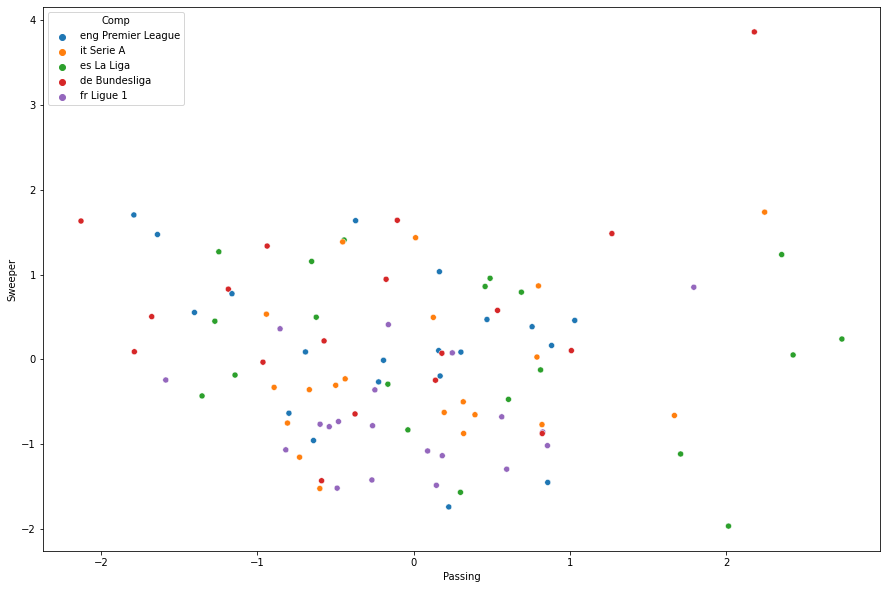

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
sns.scatterplot(data=data_withPCA, x='Passing', y='Sweeper', hue='Comp')

In [ ]:
data_withPCA.query("Line > 0.5 & Passing < 1 & Crosses > -0.5 & Sweeper > 1")

,Player,Nation,Pos,Squad,Comp,Age,Born,Played90s,GA,PKA,...,Att_per90,PassAtt_per90,PassThr_per90,GKAtt_per90,CrossAtt_per90,CrossStp_per90,Line,Passing,Crosses,Sweeper
1,Kepa Arrizabalaga,es ESP,GK,Chelsea,eng Premier League,28.317808,1994,11.5,9.0,0.0,...,7.826087,29.913043,5.043478,7.217391,14.521739,0.695652,2.832961,-1.639256,0.155366,1.473099
9,Yassine Bounou,ma MAR,GK,Sevilla,es La Liga,31.813699,1991,15.5,23.0,2.0,...,12.000000,31.354839,4.000000,6.903226,12.838710,0.903226,1.049851,-0.445246,0.103422,1.408388
66,Nick Pope,eng ENG,GK,Newcastle Utd,eng Premier League,30.775342,1992,20.0,11.0,1.0,...,11.000000,20.350000,6.550000,5.400000,12.650000,0.950000,0.916118,-0.371801,0.143557,1.636420


In [ ]:
data_withPCA.query("Age < 25")

,Player,Nation,Pos,Squad,Comp,Age,Born,Played90s,GA,PKA,...,Att_per90,PassAtt_per90,PassThr_per90,GKAtt_per90,CrossAtt_per90,CrossStp_per90,Line,Passing,Crosses,Sweeper
5,Gavin Bazunu,ie IRL,GK,Southampton,eng Premier League,20.934247,2002,20.0,35.0,0.0,...,20.650000,30.250000,4.950000,7.200000,14.100000,1.200000,-1.981435,0.881747,1.026989,0.164925
11,Marco Carnesecchi,it ITA,GK,Cremonese,it Serie A,22.575342,2000,10.0,14.0,1.0,...,15.300000,24.100000,5.600000,6.600000,10.800000,1.000000,1.451051,0.820420,-0.261985,-0.767400
13,Lucas Chevalier,fr FRA,GK,Lille,fr Ligue 1,21.224658,2001,13.0,12.0,1.0,...,10.000000,28.307692,4.384615,3.384615,11.076923,1.153846,-0.064592,-0.489873,0.114238,-1.516591
14,Oliver Christensen,dk DEN,GK,Hertha BSC,de Bundesliga,23.852055,1999,17.0,30.0,2.0,...,16.235294,30.058824,5.411765,7.411765,14.294118,1.176471,-0.956147,-0.105224,1.033785,1.640794
21,Yehvann Diouf,fr FRA,GK,Reims,fr Ligue 1,23.197260,1999,12.0,9.0,0.0,...,11.416667,25.916667,6.166667,6.666667,16.916667,1.583333,2.119717,-0.540461,2.543012,-0.792164
22,Gianluigi Donnarumma,it ITA,GK,Paris S-G,fr Ligue 1,23.920548,1999,19.0,14.0,0.0,...,3.263158,19.789474,4.368421,4.947368,9.157895,0.736842,0.648652,-1.586135,-1.223416,-0.241866
38,Alban Lafont,fr FRA,GK,Nantes,fr Ligue 1,24.010959,1999,18.0,23.0,4.0,...,14.166667,25.000000,5.444444,7.111111,14.222222,1.000000,1.049851,0.088619,0.669097,-1.078409
46,Giorgi Mamardashvili,ge GEO,GK,Valencia,es La Liga,22.328767,2000,17.0,20.0,2.0,...,8.529412,25.352941,4.470588,4.764706,11.352941,0.823529,0.247452,-0.623733,-0.456674,0.498319
52,Illan Meslier,fr FRA,GK,Leeds United,eng Premier League,22.906849,2000,19.0,33.0,2.0,...,13.789474,22.842105,5.684211,7.736842,12.210526,0.947368,-0.956147,0.164219,0.018843,1.034790
69,Aaron Ramsdale,eng ENG,GK,Arsenal,eng Premier League,24.706849,1998,19.0,16.0,2.0,...,12.210526,24.631579,4.789474,3.842105,10.947368,0.684211,0.648652,0.301769,-0.839488,0.086834


In [ ]:
data_withPCA.Nation.unique()

array(['br BRA', 'es ESP', 'it ITA', 'de GER', 'ie IRL', 'fr FRA',
       'nl NED', 'ma MAR', 'be BEL', 'dk DEN', 'sn SEN', 'mk MKD',
       'pl POL', 'eng ENG', 'fi FIN', 'ch SUI', 'ar ARG', 'pt POR',
       'ge GEO', 'rs SRB', 'si SVN', 'cm CMR', 'cz CZE', 'cg CGO',
       'ro ROU', 'wls WAL'], dtype=object)